# Soils Revealed precalculations with `Zarrs`

<a id='libraries'></a>
### Python libraries

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from affine import Affine
import xarray as xr
import dask.array as da
from dask.diagnostics import ProgressBar, Profiler, ResourceProfiler, CacheProfiler, visualize
from xhistogram.xarray import histogram
from rasterio import features
import zarr
import rioxarray
import regionmask
import gcsfs
from geocube.api.core import make_geocube
import shapely.wkb 
from shapely.ops import cascaded_union
import json
import requests
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from tqdm import tqdm

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()
from pathlib import Path 
env_path = Path('.') / '.env'

In [3]:
from dask.distributed import Client
client = Client()  # start distributed scheduler locally.  Launch dashboard
client

Client Scheduler: tcp://127.0.0.1:61305 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


<a id='utils'></a>
### Utils

<a id='df_from_carto'></a>
**df_from_carto**

In [4]:
def df_from_carto(account, query):
    """
    It gets data by querying a carto table and converts it into a GeoDataFrame.
    """
    urlCarto = f"https://{account}.carto.com/api/v2/sql"
    
    sql = {"q": query}
    r = requests.get(urlCarto, params=sql)
    
    data = r.json()
    
    df = gpd.GeoDataFrame(data.get("rows"))
    if 'the_geom' in df.columns:
        # Change geometry from WKB to WKT format
        df['geometry'] = df.apply(lambda x: shapely.wkb.loads(x['the_geom'],hex=True), axis=1 )
        df.drop(columns=['the_geom'], inplace=True)
        if 'the_geom_webmercator' in df.columns:
            df.drop(columns=['the_geom_webmercator'], inplace=True)
        df.crs = {'init': 'epsg:4326'}
        df = df.to_crs({'init': 'epsg:4326'})
        
    return df

**intersect_areas**

In [5]:
def intersect_areas(gdf, geometry):
    """
    Intersection between the areas of a GeoDataFrame and a geometry
    """
    sindex = gdf.sindex
    
    # Areas that intersect with the geometry
    possible_matches_index = list(sindex.intersection(geometry.bounds))
    possible_matches = gdf.iloc[possible_matches_index]
    
    # Intersection between the areas and the geometry
    precise_matches = possible_matches.intersection(geometry)
    
    # Replace areas with the intersected ones
    final_matches = possible_matches[~precise_matches.is_empty]
    final_matches['geometry'] = list(precise_matches[~precise_matches.is_empty])
    
    return final_matches

**plot_hist**

In [6]:
def plot_hist(x_min, count):
    width = x_min[1]-x_min[0]
    width -= width/5.
    x_min += width/(5.*2)
    per = count/count.sum()*100
    
    plt.figure(figsize=(10,5))
    
    plt.bar(x_min, per, width=width)
    
    plt.plot([0,0], [0,per.max()], color = 'k', linestyle = '--')
    
    plt.title('Soil Organic Carbon Stock')
    plt.xlabel('SOC stock t C/ha)')
    plt.ylabel('(%) of total area')

**set_lat_lon_attrs**

In [7]:
def set_lat_lon_attrs(ds):
    """ Set CF latitude and longitude attributes"""
    ds["lon"] = ds.lon.assign_attrs({
      'axis' : 'X',
       'long_name' : 'longitude',
        'standard_name' : 'longitude',
         'stored_direction' : 'increasing',
          'type' : 'double',
           'units' : 'degrees_east',
            'valid_max' : 360.0,
             'valid_min' : -180.0
             })
    ds["lat"] = ds.lat.assign_attrs({
      'axis' : 'Y',
       'long_name' : 'latitude',
        'standard_name' : 'latitude',
         'stored_direction' : 'increasing',
          'type' : 'double',
           'units' : 'degrees_north',
            'valid_max' : 90.0,
             'valid_min' : -90.0
             })
    return ds

**prepare_vector_data**

In [8]:
def prepare_vector_data(iso=None, tolerance=None):
    # Read Political boundaries:
    print('Reading Political boundaries')
    gdf_pb = gpd.read_file('../data/mbtiles/gadm36_political_boundaries/gadm36_political_boundaries.shp')
    # Select up to level 1 admin areas
    gdf_pb = gdf_pb[gdf_pb['level'] <= 1]
    #Make valid geometries
    #gdf_pb['geometry'] = gdf_pb['geometry'].apply(lambda x: x.buffer(0))
    #Simplify geometries
    if tolerance:
        gdf_pb['geometry'] = gdf_pb['geometry'].apply(lambda x: x.simplify(tolerance)) 
    
    # Read Landforms
    print('Reading Landforms')
    gdf_land = gpd.read_file('../data/mbtiles/ne_10m_geography_regions_polys/ne_10m_geography_regions_polys.shp')
    
    # Read Biomes
    print('Reading Biomes')
    gdf_bio = gpd.read_file('../data/mbtiles/bio_042_ecoregions_by_biome_1_14/bio_042_ecoregions_by_biome_1_14.shp')
    
    # Read Hydrological basins
    print('Reading Hydrological basins')
    gdf_hb = gpd.read_file('../data/mbtiles/hydrological_basins/hydrological_basins.shp')
    #Make valid geometries
    gdf_hb['geometry'] = gdf_hb['geometry'].apply(lambda x: x.buffer(0))

    vector_data = {'political_boundaries': gdf_pb, 'landforms': gdf_land, 'biomes': gdf_bio, 'hydrological_basins': gdf_hb}
    
    if iso:
        print('Intersecting areas with the selected country')
        gdf_pb = gdf_pb[gdf_pb['gid_0'] == iso]
            
        vector_data['political_boundaries'] = gdf_pb
        
        country = gdf_pb[gdf_pb['level'] == 0]['geometry'].iloc[0].buffer(0)
        
        for data_name in list(vector_data.keys())[1:]:
            print(data_name)
            vector_data[data_name] = intersect_areas(vector_data[data_name], country)
            
    # Split DataFrames to avoid overlapping geometries
    split_df_by = ['level', 'featurecla', '', 'level']
    print("splitting DataFrames")
    for n, data_name in enumerate(list(vector_data.keys())):
        if split_df_by[n]:
            df = vector_data[data_name].copy()
            del vector_data[data_name]
            categories = list(df[split_df_by[n]].unique())
            for category in categories:
                vector_data[data_name+'_'+str(category)] = df[df[split_df_by[n]] == category]    
            
    # Set index
    for data_name in list(vector_data.keys()):
        vector_data[data_name] = vector_data[data_name].reset_index(drop=True).reset_index()
        
    return vector_data

**create_ds_mask**

In [9]:
def create_ds_mask(df, ds, name, lon_name='lon', lat_name='lat'):
    # Create index column
    if 'index' not in df:
        df.reset_index(drop=True).reset_index()
    
    # Get mean ds cell area (in degrees) 
    mean_y_size = np.diff(ds.lat.values).mean()
    #print(mean_y_size)
    mean_x_size = np.diff(ds.lat.values).mean()
    #print(mean_x_size)
    mean_area = mean_y_size * mean_x_size
    print(f"The mean ds cell area is {np.round(mean_area, 6)} deg.\n")
    
    # Clip gdf to bounding box of ds
    xmin = ds.lon.min().values.tolist()
    xmax = ds.lon.max().values.tolist()
    ymin = ds.lat.min().values.tolist()
    ymax = ds.lat.max().values.tolist()
    df = df.cx[xmin:xmax, ymin:ymax]
    
    
    # Add area of geoms to gdf
    df = df.assign(area = df.area)
    df = df.assign(area_is_gt_cell = df['area'] > mean_area)
    print(f"Clipped gdf to dataset bounds, giving {len(df['index'])} potential geometries, of which {df['area_is_gt_cell'].sum()} are large enough.\n")
    
    print("Geometries smaller than mean cell size:")
    print(df.loc[df['area_is_gt_cell'] == False, ['index']])
    print("\n")

    # Extract indexes and geoms that are large enough!
    id_ints = df.loc[df['area_is_gt_cell'] == True, 'index'].values
    geoms = df.loc[df['area_is_gt_cell'] == True, 'geometry'].values
    
    print(f'Number of indexes: {len(id_ints)}')
    print(f'Number of geoms: {len(geoms)}')

    # create mask object
    da_mask = regionmask.Regions(
      name = name,
      numbers = id_ints,
      outlines = geoms)\
      .mask(ds, lon_name=lon_name, lat_name=lat_name)\
      .rename(name)

    # get the ints actually written to mask
    id_ints_mask = da_mask.to_dataframe().dropna()[name].unique()
    id_ints_mask = np.sort(id_ints_mask).astype('int')
    
    print(f'Number of ints in mask: {len(id_ints_mask)}')
    
    # update da attributes
    da_mask.attrs['id_ints'] = id_ints_mask
    da_mask = set_lat_lon_attrs(da_mask)
    return da_mask

**`rasterio` and `geopandas` can be combined with `xarray` to make converting shapefiles into raster masks pretty easy.**

In [10]:
def transform_from_latlon(lat, lon):
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

def rasterize(shapes, coords, latitude='latitude', longitude='longitude',
              fill=np.nan, **kwargs):
    """Rasterize a list of (geometry, fill_value) tuples onto the given
    xray coordinates. This only works for 1d latitude and longitude
    arrays.
    """
    transform = transform_from_latlon(coords[latitude], coords[longitude])
    out_shape = (len(coords[latitude]), len(coords[longitude]))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    spatial_coords = {latitude: coords[latitude], longitude: coords[longitude]}
    return xr.DataArray(raster, coords=spatial_coords, dims=(latitude, longitude))

In [11]:
def create_ds_mask_rasterio(df, ds, name, lon_name='lon', lat_name='lat'):
    # Create index column
    if 'index' not in df:
        df.reset_index(drop=True).reset_index()
    
    # Get mean ds cell area (in degrees) 
    mean_y_size = np.diff(ds.lat.values).mean()
    #print(mean_y_size)
    mean_x_size = np.diff(ds.lat.values).mean()
    #print(mean_x_size)
    mean_area = mean_y_size * mean_x_size
    print(f"The mean ds cell area is {np.round(mean_area, 6)} deg.\n")
    
    # Clip gdf to bounding box of ds
    xmin = ds.lon.min().values.tolist()
    xmax = ds.lon.max().values.tolist()
    ymin = ds.lat.min().values.tolist()
    ymax = ds.lat.max().values.tolist()
    df = df.cx[xmin:xmax, ymin:ymax]
    
    
    # Add area of geoms to gdf
    df = df.assign(area = df.area)
    df = df.assign(area_is_gt_cell = df['area'] > mean_area)
    print(f"Clipped gdf to dataset bounds, giving {len(df['index'])} potential geometries, of which {df['area_is_gt_cell'].sum()} are large enough.\n")
    
    print("Geometries smaller than mean cell size:")
    print(df.loc[df['area_is_gt_cell'] == False, ['index']])
    print("\n")

    # Extract indexes and geoms that are large enough!
    id_ints = df.loc[df['area_is_gt_cell'] == True, 'index'].values
    geoms = df.loc[df['area_is_gt_cell'] == True, 'geometry'].values
    
    print(f'Number of indexes: {len(id_ints)}')
    print(f'Number of geoms: {len(geoms)}')
    
    # create mask object
    shapes = zip(df.geometry.buffer(0), range(len(df)))
    da_mask = rasterize(shapes, ds.coords, longitude=lon_name, latitude=lat_name).rename(name)

    # get the ints actually written to mask
    id_ints_mask = da_mask.to_dataframe().dropna()[name].unique()
    id_ints_mask = np.sort(id_ints_mask).astype('int')
    
    print(f'Number of ints in mask: {len(id_ints_mask)}')
    
    # update da attributes
    da_mask.attrs['id_ints'] = id_ints_mask
    da_mask = set_lat_lon_attrs(da_mask)
    return da_mask

**precalculate_change**

In [12]:
def precalculate_change(df, xds, nBinds=40, bindsRange=[-50, 50]):
    indexes = xds.index.attrs.get('id_ints').astype(np.float32)
    times = xds.coords.get('time').values
    depths = xds.coords.get('depth').values
    
    Indexes = []
    Counts = []
    Bins = []
    Change = []
    Depth = []
    Dates = []
    
    for index in tqdm(indexes):
        xds_index = xds.where(xds['index'].isin(index))
        for depth in depths:
            for i in range(len(times)):
                for j in range(len(times)-1-i):
                    start_date = times[i]
                    end_date = times[i+j+1]
                    
                    # Get difference between two dates
                    diff = xds_index.loc[dict(time=end_date, depth=depth)] - xds_index.loc[dict(time=start_date, depth=depth)]
                    
                    # Get counts and binds of the histogram
                    h, bins = da.histogram(diff.stocks, bins=nBinds, range=bindsRange)
                    
                    # Compute change value
                    start_year = pd.to_datetime(start_date).year
                    end_year = pd.to_datetime(end_date).year
                    dYears = end_year - start_year
                    mean_diff = diff.stocks.mean(skipna=True).compute().values
                    change = mean_diff/dYears
                    
                    # Save values
                    Indexes.append(int(index))
                    Counts.append(h.compute())
                    Bins.append(bins)
                    Change.append(change)
                    Depth.append(depth)
                    Dates.append([start_year, end_year])
                    
    
    df_change = pd.DataFrame({"index": Indexes, "counts": Counts, "bins": Bins, "change":Change, "depth": Depth, "years": Dates})
    
    return pd.merge(df.drop(columns='geometry').reset_index(drop=True).reset_index(), 
                    df_change, 
                    how='left', 
                    on='index').drop(columns=['index'])

## Read `xarray.Dataset` from `Zarr` in Google cloud storage

In [13]:
%%time
# Connect to GS
project_name = 'soc-platform'
bucket_name = 'vizz-data-transfer'
root = bucket_name+'/SOC_maps/soil-data.zarr'
group = 'experimental-dataset-stock'
private_key = json.loads(os.getenv("PRIVATE_KEY"))

gc = gcsfs.GCSFileSystem(project=project_name, token=private_key)
store = gc.get_mapper(root)

# Return zarr group
xds = xr.open_zarr(store=store, group=group, consolidated=True)

# Change coordinates names
xds = xds.rename({'x': 'lon', 'y': 'lat'})

# Change depth coord from 0 to 1 dimensional array
depths = xds.coords.get('depth').values
if depths.ndim == 0: 
    xds = xds.squeeze().drop("depth")
    xds = xds.assign_coords({"depth": np.array([depths])})

xds

CPU times: user 205 ms, sys: 37.6 ms, total: 242 ms
Wall time: 2.63 s


,Array,Chunk
Bytes,19.74 GB,6.43 MB
Shape,"(36, 13883, 9872)","(3, 868, 617)"
Count,6145 Tasks,3072 Chunks
Type,float32,numpy.ndarray


## Read vector data

In [14]:
vector_data = prepare_vector_data(iso='ARG', tolerance=0.075)

Reading Political boundaries
Reading Landforms
Reading Biomes
Reading Hydrological basins
Intersecting areas with the selected country
landforms


<ipython-input-5-e91b7d14b175>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_matches['geometry'] = list(precise_matches[~precise_matches.is_empty])


biomes


<ipython-input-5-e91b7d14b175>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_matches['geometry'] = list(precise_matches[~precise_matches.is_empty])


hydrological_basins


<ipython-input-5-e91b7d14b175>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_matches['geometry'] = list(precise_matches[~precise_matches.is_empty])


splitting DataFrames


## Zonal statistics

**Create the data mask by rasterizing the vector data**

In [27]:
ds = xds.copy()
for name in list(vector_data.keys()):
    print(f'Create the data mask for {name}:')
    da_mask = create_ds_mask(vector_data[name], ds, name, lon_name='lon', lat_name='lat')
    
    ds[name] = da_mask

Create the data mask for biomes:
The mean ds cell area is 6e-06 deg.

Clipped gdf to dataset bounds, giving 19 potential geometries, of which 19 are large enough.

Geometries smaller than mean cell size:
Empty GeoDataFrame
Columns: [index]
Index: []


Number of indexes: 19
Number of geoms: 19
Number of ints in mask: 19
Create the data mask for political_boundaries_1:
The mean ds cell area is 6e-06 deg.

Clipped gdf to dataset bounds, giving 24 potential geometries, of which 24 are large enough.

Geometries smaller than mean cell size:
Empty GeoDataFrame
Columns: [index]
Index: []


Number of indexes: 24
Number of geoms: 24
Number of ints in mask: 24
Create the data mask for political_boundaries_0:
The mean ds cell area is 6e-06 deg.

Clipped gdf to dataset bounds, giving 1 potential geometries, of which 1 are large enough.

Geometries smaller than mean cell size:
Empty GeoDataFrame
Columns: [index]
Index: []


Number of indexes: 1
Number of geoms: 1
Number of ints in mask: 1
Create the

In [28]:
ds

,Array,Chunk
Bytes,19.74 GB,6.43 MB
Shape,"(36, 13883, 9872)","(3, 868, 617)"
Count,6145 Tasks,3072 Chunks
Type,float32,numpy.ndarray


### Histogram
#### **Example**
Select subsample:

In [29]:
ds_eg = ds.isel(time=[0,18,35]).copy()

In [88]:
indexes = ds_eg.landforms_Plain.attrs.get('id_ints').astype(np.float32)
times = ds_eg.coords.get('time').values
depths = ds_eg.coords.get('depth').values

In [90]:
ds_index = ds_eg.where(ds_eg['landforms_Plain'].isin(indexes[0])).copy()
diff = ds_index.loc[dict(time=times[2], depth=depths[0])] - ds_index.loc[dict(time=times[0], depth=depths[0])]
diff

<xarray.Dataset>
Dimensions:                 (lat: 13883, lon: 9872)
Coordinates:
  * lon                     (lon) float64 -74.7 -74.7 -74.7 ... -51.05 -51.05
  * lat                     (lat) float64 -21.79 -21.79 -21.79 ... -55.05 -55.06
    depth                   <U4 '0-30'
Data variables:
    stocks                  (lat, lon) float32 dask.array<chunksize=(868, 617), meta=np.ndarray>
    biomes                  (lat, lon) float64 nan nan nan nan ... nan nan nan
    political_boundaries_1  (lat, lon) float64 nan nan nan nan ... nan nan nan
    political_boundaries_0  (lat, lon) float64 nan nan nan nan ... nan nan nan
    landforms_Wetlands      (lat, lon) float64 nan nan nan nan ... nan nan nan
    landforms_Plain         (lat, lon) float64 nan nan nan nan ... nan nan nan
    landforms_Continent     (lat, lon) float64 nan nan nan nan ... nan nan nan
    landforms_Plateau       (lat, lon) float64 nan nan nan nan ... nan nan nan
    landforms_Island        (lat, lon) float64 nan nan nan nan ... nan nan nan
    landforms_Geoarea       (lat, lon) float64 nan nan nan nan ... nan nan nan
    landforms_Pen/cape      (lat, lon) float64 nan nan nan nan ... nan nan nan
    landforms_Range/mtn     (lat, lon) float64 nan nan nan nan ... nan nan nan
    hydrological_basins_1   (lat, lon) float64 nan nan nan nan ... nan nan nan
    hydrological_basins_0   (lat, lon) float64 nan nan nan nan ... nan nan nan

**with `xhistogram`**

In [91]:
bins = np.linspace(-50, 50, 41)
h = histogram(diff.stocks, bins=[bins], dim=['lat', 'lon'])
h

<xarray.DataArray 'histogram_stocks' (stocks_bin: 40)>
dask.array<getitem, shape=(40,), dtype=int64, chunksize=(40,), chunktype=numpy.ndarray>
Coordinates:
  * stocks_bin  (stocks_bin) float64 -48.75 -46.25 -43.75 ... 43.75 46.25 48.75

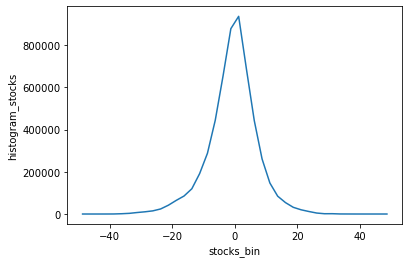

In [92]:
with ProgressBar():
    h.plot()

Plot change distribution

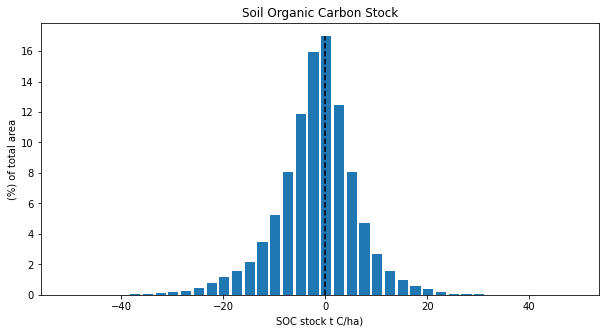

In [93]:
with ProgressBar():
    count = h.values
    
x_min = bins[:-1]
plot_hist(x_min, count)

**with `da.histogram`**

In [94]:
h, bins = da.histogram(diff.stocks, bins=40, range=[-50, 50])

Plot change distribution

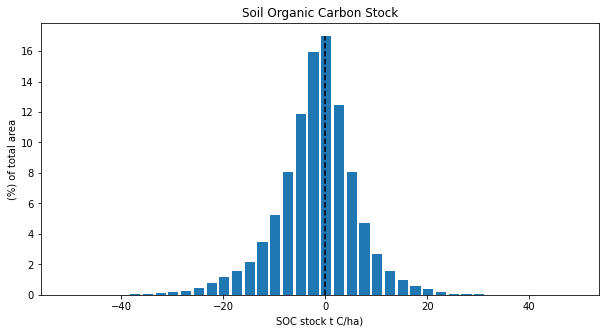

In [95]:
with ProgressBar():
    count = h.compute()

x_min = bins[:-1]
plot_hist(x_min, count)

**Display change value**

In [96]:
years = pd.to_datetime(times[2]).year - pd.to_datetime(times[0]).year
mean_diff = diff.stocks.mean(skipna=True).compute().values
change = mean_diff/years

In [97]:
print(f'Soil Organic Carbon Stock Change: {change} t C/ha year')

Soil Organic Carbon Stock Change: -0.019627460411616733 t C/ha year


#### **Entire` DataFrame`**

In [33]:
def precalculate_change(df, xds, name, nBinds=40, bindsRange=[-50, 50]):
    indexes = xds[name].attrs.get('id_ints').astype(np.float32)
    times = xds.coords.get('time').values
    depths = xds.coords.get('depth').values
    
    Indexes = []
    Counts = []
    Bins = []
    Change = []
    Depth = []
    Dates = []
    
    for index in tqdm(indexes):
        xds_index = xds.where(xds[name].isin(index))
        for depth in depths:
            for i in range(len(times)):
                for j in range(len(times)-1-i):
                    start_date = times[i]
                    end_date = times[i+j+1]
                    
                    # Get difference between two dates
                    diff = xds_index.loc[dict(time=end_date, depth=depth)] - xds_index.loc[dict(time=start_date, depth=depth)]
                    
                    # Get counts and binds of the histogram
                    h, bins = da.histogram(diff.stocks, bins=nBinds, range=bindsRange)
                    
                    # Compute change value
                    start_year = pd.to_datetime(start_date).year
                    end_year = pd.to_datetime(end_date).year
                    dYears = end_year - start_year
                    mean_diff = diff.stocks.mean(skipna=True).compute().values
                    change = mean_diff/dYears
                    
                    # Save values
                    Indexes.append(int(index))
                    Counts.append(h.compute())
                    Bins.append(bins)
                    Change.append(change)
                    Depth.append(depth)
                    Dates.append([start_year, end_year])
                    
    
    df_change = pd.DataFrame({"index": Indexes, "counts": Counts, "bins": Bins, "change":Change, "depth": Depth, "years": Dates})
    
    return pd.merge(df.drop(columns='geometry').reset_index(drop=True).reset_index(), 
                    df_change, 
                    how='left', 
                    on='index').drop(columns=['index'])

In [16]:
vector_data_eg = {key: vector_data[key] for key in ['landforms_Plain', 'landforms_Continent']}

In [17]:
vector_data_out = vector_data_eg.keys()

In [ ]:
name = list(vector_data_out)[0]
df = vector_data[name].copy()
df_new = precalculate_change(df, ds_eg, name, nBinds=40, bindsRange=[-50, 50])

  0%|          | 0/3 [00:00<?, ?it/s]

In [32]:
ds_eg[name]

<xarray.DataArray 'landforms_Plain' (lat: 13883, lon: 9872)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lon      (lon) float64 -74.7 -74.7 -74.7 -74.7 ... -51.05 -51.05 -51.05
  * lat      (lat) float64 -21.79 -21.79 -21.79 -21.79 ... -55.05 -55.05 -55.06
Attributes:
    id_ints:  [1 2 3]

In [ ]:
vector_data_out = vector_data_eg.keys()
for name in list(vector_data_eg.keys()):
    print(f'Create the DataFrame for {name}:')
    with ProgressBar():
        vector_data_out['name'] = precalculate_change(vector_data[name].copy(), ds_eg, name, nBinds=40, bindsRange=[-50, 50])

  0%|          | 0/3 [00:00<?, ?it/s]

Create the DataFrame for landforms_Plain:


In [112]:
ds = xds.copy()
for name in list(vector_data.keys()):
    print(f'Create the data mask for {name}:')
    da_mask = create_ds_mask(vector_data[name], ds_eg, name, lon_name='lon', lat_name='lat')
    
    ds[name] = da_mask

In [ ]:
%%time
with ProgressBar():
    result = precalculate_change(df, xds, nBinds=40, bindsRange=[-50, 50])

In [ ]:
result

**Plot change distribution**

In [ ]:
index = 0
count = result['counts'].iloc[index].copy()
bins = result['bins'].iloc[index].copy()
change = result['change'].iloc[index].copy()
x_min = bins[:-1]
per = count/count.sum()*100
print(f'Soil Organic Carbon Stock Change: {change} t C/ha year')
plot_hist(x_min, count)

### Mean value
**Example**

In [ ]:
grouped_xds = xds.groupby(xds.index)
grid_mean = grouped_xds.mean().rename({"stocks": "mean"})
grid_mean.to_dataframe()

In [ ]:
def transform_from_latlon(lat, lon):
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

def rasterize(shapes, coords, latitude='latitude', longitude='longitude',
              fill=np.nan, **kwargs):
    """Rasterize a list of (geometry, fill_value) tuples onto the given
    xray coordinates. This only works for 1d latitude and longitude
    arrays.
    """
    transform = transform_from_latlon(coords[latitude], coords[longitude])
    out_shape = (len(coords[latitude]), len(coords[longitude]))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    spatial_coords = {latitude: coords[latitude], longitude: coords[longitude]}
    return xr.DataArray(raster, coords=spatial_coords, dims=(latitude, longitude))

In [ ]:
vector_data.keys()

In [ ]:
#gdf = vector_data['political_boundaries'][vector_data['political_boundaries']['level'] == 1]
gdf = vector_data['political_boundaries']
#gdf = vector_data['landforms']
#gdf = vector_data['hydrological_basins'][vector_data['hydrological_basins']['level'] == 1]
#gdf = vector_data['biomes']
gdf.head()

In [ ]:
shapes = zip(gdf.geometry.buffer(0), range(len(gdf)))

In [ ]:
ds = xds.copy()
ds['index'] = rasterize(shapes, ds.coords, longitude='lon', latitude='lat')

In [ ]:
ds.index.plot.imshow()

In [ ]:
np.sort(ds.index.to_dataframe().dropna()['index'].unique())

In [ ]:
index = 0
(ds.index == index).plot.imshow()

In [ ]:
(ds.stocks
 .isel(time=slice(12))
 .where(ds.index == index)
 .mean(['lon', 'lat'])).compute()

In [ ]:
xmin, ymax, xmax, ymin = gdf.iloc[index]['geometry'].bounds

(ds.stocks
 .isel(time=slice(12))
 .where(ds.index == index)
 .sel(lon=slice(xmin, xmax), lat=slice(ymin, ymax))
 .plot.imshow(col='time', col_wrap=4))

In [ ]:
(ds.stocks
 .isel(time=slice(12))
 .where(ds.index == index)
 .sel(lon=slice(xmin, xmax), lat=slice(ymin, ymax))
 .mean(['lon', 'lat'])
 .plot())

In [ ]:
ds_index = ds.where(ds.index == index)

In [ ]:
ds_index